In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
from scipy import misc
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import csgraph
from scipy import linalg
from pysheds.grid import Grid
from scipy import ndimage
from matplotlib import colors
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec

%matplotlib inline

In [2]:
sns.set_palette('husl', 2)

In [3]:
grid = Grid.from_raster('/home/mdbartos/Downloads/n30w100_dir/n30w100_dir',
                 data_name='dir')

In [4]:
grid.read_raster('/home/mdbartos/Downloads/n30w100_con/n30w100_con',
                 data_name='dem')

In [5]:
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')
# Clip the bounding box to the catchment
grid.clip_to('catch', precision=5)

grid.accumulation(data='catch', dirmap=dirmap, pad_inplace=False, out_name='acc')

In [6]:
profiles, connections = grid.extract_profiles('catch', grid.acc > 25)

In [7]:
geom = grid.extract_river_network('catch', grid.acc > 25)

# Lo Diffusion + advection

In [8]:
dx = 60. * (np.asarray([profile.size for profile in profiles]) + 1)
n = max(max(connections.keys()), max(connections.values())) + 1
s = np.ones(n)
I = np.eye(n)
u = 1.0*np.ones(n)
D = (u * dx / 10).mean()*np.ones(n)
dt = 1
I[0, 0] = 0

U = np.zeros((n, n))
W = np.zeros((n, n))

for i, j in connections.items():
    # Confirmed as i
    U[j, i] = u[i] * dt / dx[i]
    W[i, j] = u[i] * dt / dx[i]
    
V = np.diag(W @ s)

X = np.zeros((n, n))

for i, j in connections.items():
    X[i, j] = 2 / (dx[i] + dx[j])
    X[j, i] = 2 / (dx[i] + dx[j])
    
Y = np.diag(X @ s)

Z = np.diag(D * dt / dx)
S = (U - V) - Z @ (Y - X) + I

In [9]:
np.imag(np.linalg.eig(S)[0]).max(), np.imag(np.linalg.eig(S)[0]).min(), np.real(np.linalg.eig(S)[0]).max(), np.real(np.linalg.eig(S)[0]).min()

(0.0, 0.0, 0.9997196165216445, -0.0027755206889173286)

In [10]:
C = np.eye(n)
ns = 11

In [11]:
W_c = linalg.solve_discrete_lyapunov(S, C)
st = np.argsort(np.diag(W_c))[::-1][:ns]

In [12]:
W_o = linalg.solve_discrete_lyapunov(S.T, C)

In [13]:
np.random.seed(0)
x0 = np.ones(S.shape[0])

In [14]:
from numba import njit

In [15]:
sr = np.asarray([  1, 128, 136,  52,  64,  92, 194,   9, 143, 161, 191,  13,  71,
       15, 125,  77, 141, 198,  58, 150, 102,  12,  88, 164, 204,   2,
       70,  87, 159, 177, 197,  22])

In [16]:
st = np.asarray([  5,   8,  14,  42,  26,  76,  51,  89,  45,  55,  63,  83,  28,
                   1,  65,  85, 104,  93, 103, 121, 115,  13,  11, 140,   9, 194,
                 107,   6,  71,  64,  31,  40])

In [17]:
@njit(fastmath=True)
def compute_multi_x0s(X0, S, C, T):
    Ac = np.eye(S.shape[0])
    Wo_r = np.zeros(S.shape)
    R_r = np.zeros(X0.shape)
    X0_hat = np.zeros(X0.shape)
    m = X0.shape[0]
    for _ in range(T):
        AC = C @ Ac
        Wo_r += (AC.T @ AC)
        for i in range(m):
            y = AC @ X0[i]
            R_r[i] += (AC.T @ y)
        Ac = S @ Ac
    Wo_r_inv = np.linalg.pinv(Wo_r)
    for i in range(m):
        X0_hat[i] = (Wo_r_inv @ R_r[i])
    return X0_hat

In [18]:
C = np.eye(S.shape[0])[sr[:11]]
X0 = np.vstack([x0, x0, x0, x0])

In [19]:
%time x0_hats = compute_multi_x0s(X0, S, C, 4000)

CPU times: user 24.9 s, sys: 6.35 s, total: 31.3 s
Wall time: 7.74 s


In [20]:
Adj = np.zeros((n, n))

for i, j in connections.items():
    # Confirmed as i
    Adj[j, i] = 1
    Adj[i, j] = 1
    
Lap = sparse.csgraph.laplacian(Adj)

In [21]:
L, U = np.linalg.eigh(Lap)
ghat = np.exp(-100*L)

In [22]:
np.random.seed(0)
trials = 200

T = np.random.choice(len(U), size=trials, replace=False)
ghat = [np.exp(np.minimum((100*np.random.randn() - 100), -1)*L) for _ in range(trials)]

In [23]:
X0 = np.vstack([(U @ np.diag(ghat[i]) @ U[T[i]]).ravel() for i in range(trials)])

In [24]:
X0 = X0 / np.linalg.norm(X0, axis=1).reshape(-1, 1)

In [25]:
start = time.time()
x0_hats = compute_multi_x0s(X0, S, C, 4000)
end = time.time()
print(end - start, ' s')

7.578350305557251  s


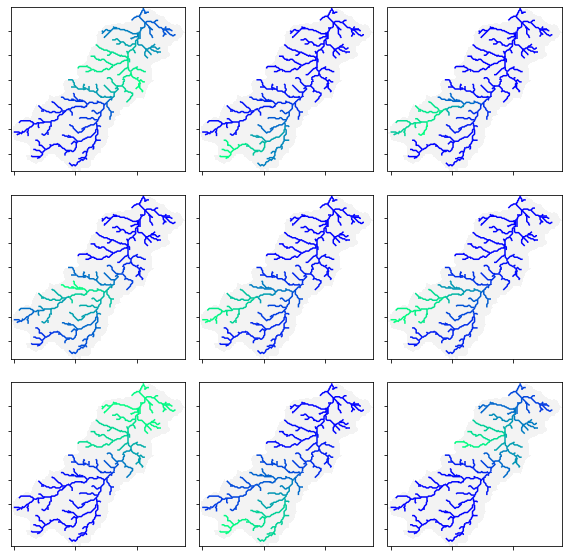

In [26]:
fig, ax = plt.subplots(3, 3, figsize=(8,8))

for i in range(9):
    ax.flat[i].set_facecolor('w')
    ax.flat[i].xaxis.set_ticklabels([])
    ax.flat[i].yaxis.set_ticklabels([])

segs = [np.asarray(branch['geometry']['coordinates']) for branch in geom['features']]

for i in range(9):
    ax.flat[i].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
                      vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
    mag = X0[i]
    norm = matplotlib.colors.Normalize(vmin=mag.min(), vmax=mag.max())
    mapper = cm.ScalarMappable(norm=norm, cmap='winter')
    colors = mapper.to_rgba(mag)
    line_segments = LineCollection(segs, colors=colors, linewidths=1.5)
    im = ax.flat[i].add_collection(line_segments)
    ax.flat[i].autoscale()
    
plt.tight_layout()
plt.show()
#plt.savefig('heat_kernels_t100.png')

# Rank-based

In [27]:
C = np.eye(len(S))
X0_hats_r = {}

first_start = time.time()

for i in range(1, len(sr)):
    sensors = sr[:i].tolist()
    Ci = C[sensors]
    start = time.time()
    x0_hats_i = compute_multi_x0s(X0, S, Ci, 3600)
    end = time.time()
    print(f'{i}: ', end - start, ' s')
    X0_hats_r[i] = x0_hats_i
    
print('Total: ', end - first_start, ' s')

1:  5.1121721267700195  s
2:  5.3809874057769775  s
3:  5.641917705535889  s
4:  5.6179234981536865  s
5:  5.950946092605591  s
6:  6.240763187408447  s
7:  6.349416971206665  s
8:  6.354503154754639  s
9:  6.546662092208862  s
10:  6.665334463119507  s
11:  6.919095277786255  s
12:  6.893658638000488  s
13:  7.050539016723633  s
14:  7.338671922683716  s
15:  7.4246931076049805  s
16:  7.550046920776367  s
17:  7.98766827583313  s
18:  8.033258199691772  s
19:  8.168648719787598  s
20:  8.209306955337524  s
21:  8.657029628753662  s
22:  8.811021566390991  s
23:  8.916736602783203  s
24:  9.077987670898438  s
25:  9.306634902954102  s
26:  9.581563949584961  s
27:  9.779516696929932  s
28:  9.759276866912842  s
29:  9.947666645050049  s
30:  10.096765995025635  s
31:  10.318551063537598  s
Total:  239.71022605895996  s


# Trace-based

In [28]:
C = np.eye(len(S))
X0_hats_t = {}

first_start = time.time()

for i in range(1, len(st)):
    sensors = st[:i].tolist()
    Ci = C[sensors]
    start = time.time()
    x0_hats_i = compute_multi_x0s(X0, S, Ci, 3600)
    end = time.time()
    print(f'{i}: ', end - start, ' s')
    X0_hats_t[i] = x0_hats_i
    
print('Total: ', end - first_start, ' s')

1:  5.112292528152466  s
2:  5.364452123641968  s
3:  5.665099859237671  s
4:  5.6110382080078125  s
5:  5.91336727142334  s
6:  6.19813084602356  s
7:  6.333972692489624  s
8:  6.629284858703613  s
9:  6.514134407043457  s
10:  6.578885555267334  s
11:  6.7913689613342285  s
12:  6.865018606185913  s
13:  7.0033485889434814  s
14:  7.234812259674072  s
15:  7.391557216644287  s
16:  7.614781856536865  s
17:  7.572826862335205  s
18:  7.950587511062622  s
19:  8.108787775039673  s
20:  8.15208387374878  s
21:  8.627467393875122  s
22:  8.617995738983154  s
23:  8.965798139572144  s
24:  9.000434637069702  s
25:  9.288678169250488  s
26:  9.469580888748169  s
27:  9.669687509536743  s
28:  9.693897485733032  s
29:  9.832557678222656  s
30:  9.990066289901733  s
31:  10.229069471359253  s
Total:  238.01189017295837  s


# Random placement

In [29]:
np.random.seed(0)
sss = [np.random.choice(np.arange(1, len(Adj)), size=len(sr), replace=False) for _ in range(10)]

In [30]:
C = np.eye(len(S))
X0_hats_U = []

for it, ss in enumerate(sss[:]):
    first_start = time.time()
    X0_hats_ui = {}
    print(it)
    for i in range(1, len(ss)):
        sensors = ss[:i].tolist()
        Ci = C[sensors]
        start = time.time()
        x0_hats_i = compute_multi_x0s(X0, S, Ci, 3600)
        end = time.time()
        print(f'{i}: ', end - start, ' s')
        X0_hats_ui[i] = x0_hats_i
    print('Total: ', end - first_start, ' s')
    X0_hats_U.append(X0_hats_ui)

0
1:  5.1068737506866455  s
2:  5.344251871109009  s
3:  5.665699005126953  s
4:  5.648569583892822  s
5:  5.924322128295898  s
6:  6.132441520690918  s
7:  6.259803771972656  s
8:  6.294262409210205  s
9:  6.580387592315674  s
10:  6.71566104888916  s
11:  6.877215147018433  s
12:  6.943089246749878  s
13:  7.028927564620972  s
14:  7.265291452407837  s
15:  7.45820164680481  s
16:  7.455518007278442  s
17:  7.618298530578613  s
18:  8.113157749176025  s
19:  8.314273595809937  s
20:  8.220126628875732  s
21:  8.595333337783813  s
22:  8.613725900650024  s
23:  8.74030089378357  s
24:  8.827283382415771  s
25:  8.963917016983032  s
26:  9.32174015045166  s
27:  9.433807373046875  s
28:  9.646707534790039  s
29:  9.625866174697876  s
30:  10.03391718864441  s
31:  10.081382274627686  s
Total:  236.8705871105194  s
1
1:  5.204493999481201  s
2:  5.3471620082855225  s
3:  5.6803412437438965  s
4:  5.658367156982422  s
5:  5.951849937438965  s
6:  6.121683835983276  s
7:  6.31028461456298

In [31]:
mse_by_num_sensors_r = np.asarray([((X0_hats_r[i] - X0)**2).sum() / trials for i in range(1, 32)])
mse_by_num_sensors_t = np.asarray([((X0_hats_t[i] - X0)**2).sum() / trials for i in range(1, 32)])
mse_by_num_sensors_U = [np.asarray([((X0_hats_u[i] - X0)**2).sum() / trials for i in range(1, 32)])
                        for X0_hats_u in X0_hats_U]

In [33]:
sns.set()

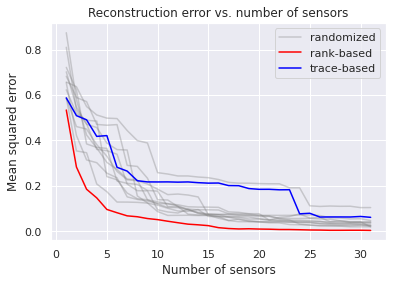

In [35]:
plt.plot(np.arange(1, 32), mse_by_num_sensors_U[0], label='randomized', c='0.5', alpha=0.35)
for mse_by_num_sensors_u in mse_by_num_sensors_U[1:]:
    plt.plot(np.arange(1, 32), mse_by_num_sensors_u, c='0.5', alpha=0.35)
plt.plot(np.arange(1, 32), mse_by_num_sensors_r, label='rank-based', c='red')
plt.plot(np.arange(1, 32), mse_by_num_sensors_t, label='trace-based', c='blue')

plt.xlabel('Number of sensors')
plt.ylabel('Mean squared error')
plt.title('Reconstruction error vs. number of sensors')
#plt.xlim(1 - 0.2, 31 + 0.2)
plt.legend()

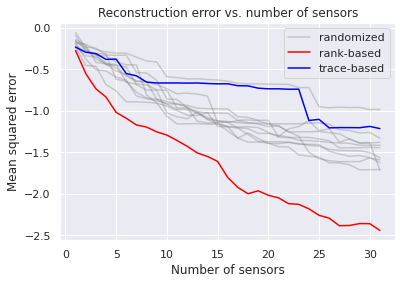

In [40]:
plt.plot(np.arange(1, 32), np.log10(mse_by_num_sensors_U[0]), label='randomized', c='0.5', alpha=0.35)
for mse_by_num_sensors_u in mse_by_num_sensors_U[1:]:
    plt.plot(np.arange(1, 32), np.log10(mse_by_num_sensors_u), c='0.5', alpha=0.35)
plt.plot(np.arange(1, 32), np.log10(mse_by_num_sensors_r), label='rank-based', c='red')
plt.plot(np.arange(1, 32), np.log10(mse_by_num_sensors_t), label='trace-based', c='blue')

plt.xlabel('Number of sensors')
plt.ylabel('Mean squared error')
plt.title('Reconstruction error vs. number of sensors')
#plt.xlim(1 - 0.2, 31 + 0.2)
plt.legend()

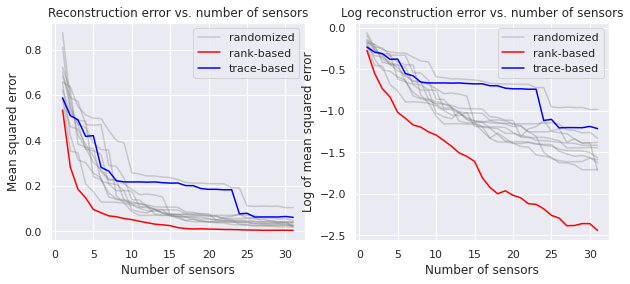

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(np.arange(1, 32), mse_by_num_sensors_U[0], label='randomized', c='0.5', alpha=0.35)
for mse_by_num_sensors_u in mse_by_num_sensors_U[1:]:
    ax[0].plot(np.arange(1, 32), mse_by_num_sensors_u, c='0.5', alpha=0.35)
ax[0].plot(np.arange(1, 32), mse_by_num_sensors_r, label='rank-based', c='red')
ax[0].plot(np.arange(1, 32), mse_by_num_sensors_t, label='trace-based', c='blue')

ax[0].set_xlabel('Number of sensors')
ax[0].set_ylabel('Mean squared error')
ax[0].set_title('Reconstruction error vs. number of sensors')
ax[0].legend()

ax[1].plot(np.arange(1, 32), np.log10(mse_by_num_sensors_U[0]), label='randomized', c='0.5', alpha=0.35)
for mse_by_num_sensors_u in mse_by_num_sensors_U[1:]:
    ax[1].plot(np.arange(1, 32), np.log10(mse_by_num_sensors_u), c='0.5', alpha=0.35)
ax[1].plot(np.arange(1, 32), np.log10(mse_by_num_sensors_r), label='rank-based', c='red')
ax[1].plot(np.arange(1, 32), np.log10(mse_by_num_sensors_t), label='trace-based', c='blue')

ax[1].set_xlabel('Number of sensors')
ax[1].set_ylabel('Log of mean squared error')
ax[1].set_title('Log reconstruction error vs. number of sensors')
ax[1].legend()

In [41]:
std_by_num_sensors_r = np.asarray([((X0_hats_r[i] - X0)).std() for i in range(1, 32)])
std_by_num_sensors_t = np.asarray([((X0_hats_t[i] - X0)).std() for i in range(1, 32)])
std_by_num_sensors_u0 = np.asarray([((X0_hats_U[0][i] - X0)).std() for i in range(1, 32)])

In [36]:
import pickle

In [37]:
with open('X0_hat_r.p', 'wb') as outfile:
    pickle.dump(X0_hats_r, outfile)

In [38]:
with open('X0_hat_t.p', 'wb') as outfile:
    pickle.dump(X0_hats_t, outfile)

In [39]:
for i in range(len(X0_hats_U)):
    with open(f'X0_hat_u{i}.p', 'wb') as outfile:
        pickle.dump(X0_hats_U[i], outfile)

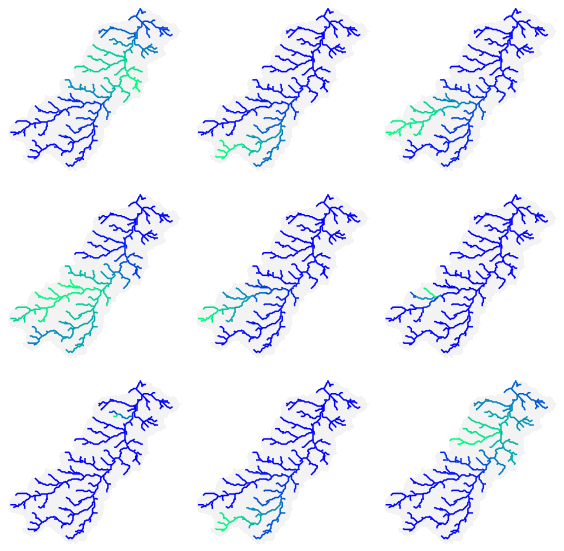

In [49]:
fig, ax = plt.subplots(3, 3, figsize=(8,8))

for i in range(9):
    ax.flat[i].set_facecolor('w')
    ax.flat[i].xaxis.set_ticklabels([])
    ax.flat[i].yaxis.set_ticklabels([])

segs = [np.asarray(branch['geometry']['coordinates']) for branch in geom['features']]

for i in range(9):
    ax.flat[i].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
                      vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
    ghat_i = np.exp(np.minimum((100*np.random.randn() - 100), -1)*L)
    mag = (U @ np.diag(ghat_i) @ U[T[i]]).ravel()
    norm = matplotlib.colors.Normalize(vmin=mag.min(), vmax=mag.max())
    mapper = cm.ScalarMappable(norm=norm, cmap='winter')
    colors = mapper.to_rgba(mag)
    line_segments = LineCollection(segs, colors=colors, linewidths=1.5)
    im = ax.flat[i].add_collection(line_segments)
    ax.flat[i].autoscale()
    
plt.tight_layout()
plt.show()
#plt.savefig('heat_kernels_t100.png')